In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

## NY Times

In [2]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, parse_dates=[0])  # Cols: date, state, fips, cases, deaths 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11289 entries, 0 to 11288
Data columns (total 5 columns):
date      11289 non-null datetime64[ns]
state     11289 non-null object
fips      11289 non-null int64
cases     11289 non-null int64
deaths    11289 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 441.1+ KB


The **fips** code can be used for getting the location info for the plots. Rest are self-understandable.

## Wikipedia population data

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
pop_df = pd.read_html(url)[0]

pop_df.head()

Rank              State         Census population                   \
  Current 2010         State Estimate, July 1, 2019[8] April 1, 2010[9]   
0     1.0  1.0    California                  39512223         37253956   
1     2.0  2.0         Texas                  28995881         25145561   
2     3.0  4.0       Florida                  21477737         18801310   
3     4.0  3.0      New York                  19453561         19378102   
4     5.0  6.0  Pennsylvania                  12801989         12702379   

  Change, 2010–2019             Total U.S. House of Representatives Seats  \
    Percent[note 3]    Absolute Total U.S. House of Representatives Seats   
0              6.1%  +2,257,700                                        53   
1             15.3%  +3,850,320                                        36   
2             14.2%  +2,676,427                                        27   
3              0.4%     +75,459                                        27   
4              0.8%     +99,610                                        18   

  Estimated population per electoral vote, 2019[note 1]  \
  Estimated population per electoral vote, 2019[note 1]   
0                                             718404      
1                                             763050      
2                                             740611      
3                                             670812      
4                                             640099      

  Census population per House seat          \
                   Estimated, 2019    2010   
0                           745514  702885   
1                           805441  698503   
2                           795472  696468   
3                           720502  717707   
4                           711222  705715   

  Percent of the total U.S. population, 2019[note 2]  
  Percent of the total U.S. population, 2019[note 2]  
0                                             11.91%  
1                                              8.74%  
2                                              6.47%  
3                                              5.86%  
4                                              3.86%

In [4]:
pop_df = pop_df.iloc[:,2:4]
pop_df = pop_df.droplevel(0, axis=1)
pop_df.tail(10)

,State,"Estimate, July 1, 2019[8]"
50,Vermont,623989
51,Wyoming,578759
52,Guam,"168,485[10]"
53,U.S. Virgin Islands,"106,235[12]"
54,Northern Mariana Islands,"51,433[14]"
55,American Samoa,"49,437[16]"
56,Contiguous United States,325386357
57,The fifty states,327533795
58,Fifty states + D.C.,328239523
59,Total U.S. (including D.C. and territories),331808807


### Pre-processing population data

In [5]:
# Checking states names that are same before merging

s_df = set(df.state.unique())
s_pop = set(pop_df.State)

intersect = s_df.intersection(s_pop)
intersect = list(intersect)
print(f'For {len(intersect)} states, the names are common.')

print(f'\nState names in population data not common are:')
for state in s_pop.difference(intersect):
    print(state)
print(f'\nState names in COVID-19 data not common are:')
for state in s_df.difference(intersect):
    print(state)

For 54 states, the names are common.

State names in population data not common are:
Fifty states + D.C.
American Samoa
The fifty states
Contiguous United States
Total U.S. (including D.C. and territories)
U.S. Virgin Islands

State names in COVID-19 data not common are:
Virgin Islands


It's best to remove the least populous territories as they're bound to underfit and the total counts as they won't be merged eventually. With data being sorted in the correct order, the data from `pop_df` before 52nd entry is enough. Thus, keeping only data till Wyoming for this study.

In [6]:
pop_df = pop_df[:52]
pop_df.tail()

,State,"Estimate, July 1, 2019[8]"
47,North Dakota,762062
48,Alaska,731545
49,District of Columbia,705749
50,Vermont,623989
51,Wyoming,578759


In [7]:
import re
import warnings
warnings.filterwarnings("ignore")

def pre_process(total_pop):
    '''Pre-process population values where in some cases the references might 
    have '...[..]' pattern signifying reference
    '''
    try:
        num = int(total_pop)
    except:
        m = re.match(r'\d+[\d+]', total_pop)
        num = int(m.group(0))

    return num

pop_df.rename(columns={pop_df.columns[1]: 'Recent_population'}, inplace=True)

pop_df['Recent_population'] = pop_df['Recent_population'].apply(pre_process)

pop_df.sort_values(by='Recent_population')
pop_df.head()

,State,Recent_population
0,California,39512223
1,Texas,28995881
2,Florida,21477737
3,New York,19453561
4,Pennsylvania,12801989


# Pre-processing

Either merge with population data or just per day analysis

## Merge with population data

Do if demographic data is needed (skipping for now)

In [8]:
df = df.sort_values(by=['state', 'date'])#.set_index('date')
df

,date,state,fips,cases,deaths
586,2020-03-13,Alabama,1,6,0
637,2020-03-14,Alabama,1,12,0
689,2020-03-15,Alabama,1,23,0
742,2020-03-16,Alabama,1,29,0
795,2020-03-17,Alabama,1,39,0
...,...,...,...,...,...
11068,2020-09-19,Wyoming,56,4780,49
11123,2020-09-20,Wyoming,56,4871,49
11178,2020-09-21,Wyoming,56,4944,49
11233,2020-09-22,Wyoming,56,5016,49


In [9]:
data = pd.merge(df, pop_df, left_on='state', right_on='State').drop(columns='State')

data

,date,state,fips,cases,deaths,Recent_population
0,2020-03-13,Alabama,1,6,0,4903185
1,2020-03-14,Alabama,1,12,0,4903185
2,2020-03-15,Alabama,1,23,0,4903185
3,2020-03-16,Alabama,1,29,0,4903185
4,2020-03-17,Alabama,1,39,0,4903185
...,...,...,...,...,...,...
10717,2020-09-19,Wyoming,56,4780,49,578759
10718,2020-09-20,Wyoming,56,4871,49,578759
10719,2020-09-21,Wyoming,56,4944,49,578759
10720,2020-09-22,Wyoming,56,5016,49,578759


# Analysis

 ## State-wise Analysis

For the model, before scaling, it's best to see if state population indicates some pattern

Pearson coefficient for cases:0.956
Pearson coefficient for deaths:0.760


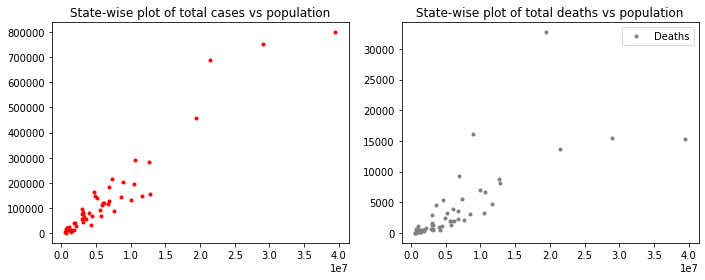

In [17]:
import scipy.stats

total_pop = []
total_cases = []
total_deaths = []

for s in data.state.unique():
    sub = data[data.state==s].iloc[-1]
    total_pop.append(sub.Recent_population)
    total_cases.append(sub.cases)
    total_deaths.append(sub.deaths)

fig = plt.figure(figsize=(10,4))    
ax1 = fig.add_subplot(1,2,1)
ax1.plot(total_pop, total_cases, 'r.', label='Cases')    
ax1.set_title('State-wise plot of total cases vs population')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('State-wise plot of total deaths vs population')
ax2.plot(total_pop, total_deaths, 'grey', ls='', marker='.', label='Deaths')    
ax2.legend()
fig.tight_layout()

pearson_cases, _ = scipy.stats.pearsonr(total_pop, total_cases)
pearson_deaths, _ = scipy.stats.pearsonr(total_pop, total_deaths)

print(f'Pearson coefficient for cases:{pearson_cases:0.3f}')
print(f'Pearson coefficient for deaths:{pearson_deaths:0.3f}')

For the reported cases, a linear trend with respect to population is seen. For the total deaths, the trend is that some states have handled better than the rest, and although the Pearson coefficient is only ~0.76, it is still a good indicator.

In [18]:
## Add later if needed

data['cases_per_capita'] = data.cases / data.Recent_population
data['deaths_per_capita'] = data.deaths / data.Recent_population

data = data.set_index('date')

data.head()

,state,fips,cases,deaths,cases_per_capita,deaths_per_capita
date,,,,,,
2020-03-13,Alabama,1,6,0,0.000001,0.0
2020-03-14,Alabama,1,12,0,0.000002,0.0
2020-03-15,Alabama,1,23,0,0.000005,0.0
2020-03-16,Alabama,1,29,0,0.000006,0.0
2020-03-17,Alabama,1,39,0,0.000008,0.0


Let's analyze the growth pattern across various states

Referring the great tutorial in: https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

In [20]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

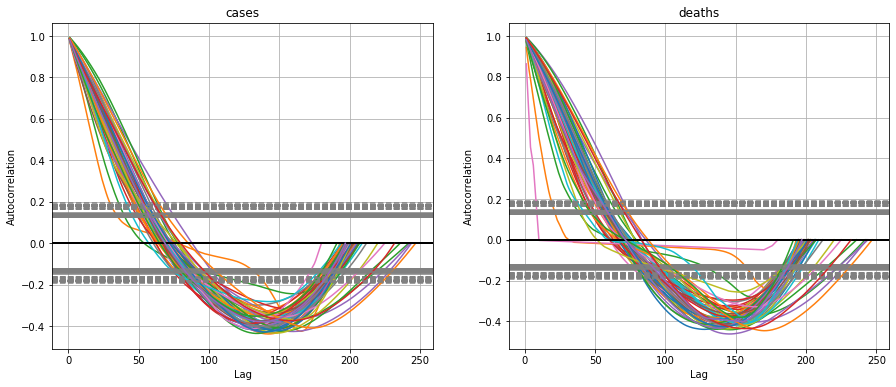

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,6))

colname = ['cases', 'deaths']

for c, col in enumerate(colname):
    for i, s in enumerate(df.state.unique()):
        subset = df[df.state == s][col]
        autocorrelation_plot(subset, ax=axes[c])
        axes[c].set_title(col)

The auto-correlation is obviously very high. At a lag of 10 for all states, the auto-correlation for cases is above 0.75 for most cases. 

We can confirm this with a lag plot for all states

In [44]:
def plot_fn(colname, plot_type, **kwargs):
    # 13 rows and 4 cols
    fig, axes = plt.subplots(nrows=13, ncols=4, sharex=kwargs['sharex'], constrained_layout=True,
                             sharey=kwargs['sharex'], figsize=(15,45))
    
    for i, s in enumerate(data.state.unique()):
        r, c = i//4, i%4
        subset = data[data.state == s][colname]
        if plot_type=='autocorr':
            autocorrelation_plot(subset, ax=axes[r,c])
            axes[r,c].set_title(s)
            
        if plot_type=='lag':
            lag = kwargs['lag']
            lag_plot(subset, lag=lag, ax=axes[r,c])
            axes[r,c].set_title(f'Lag: {lag} for {s}')
                                

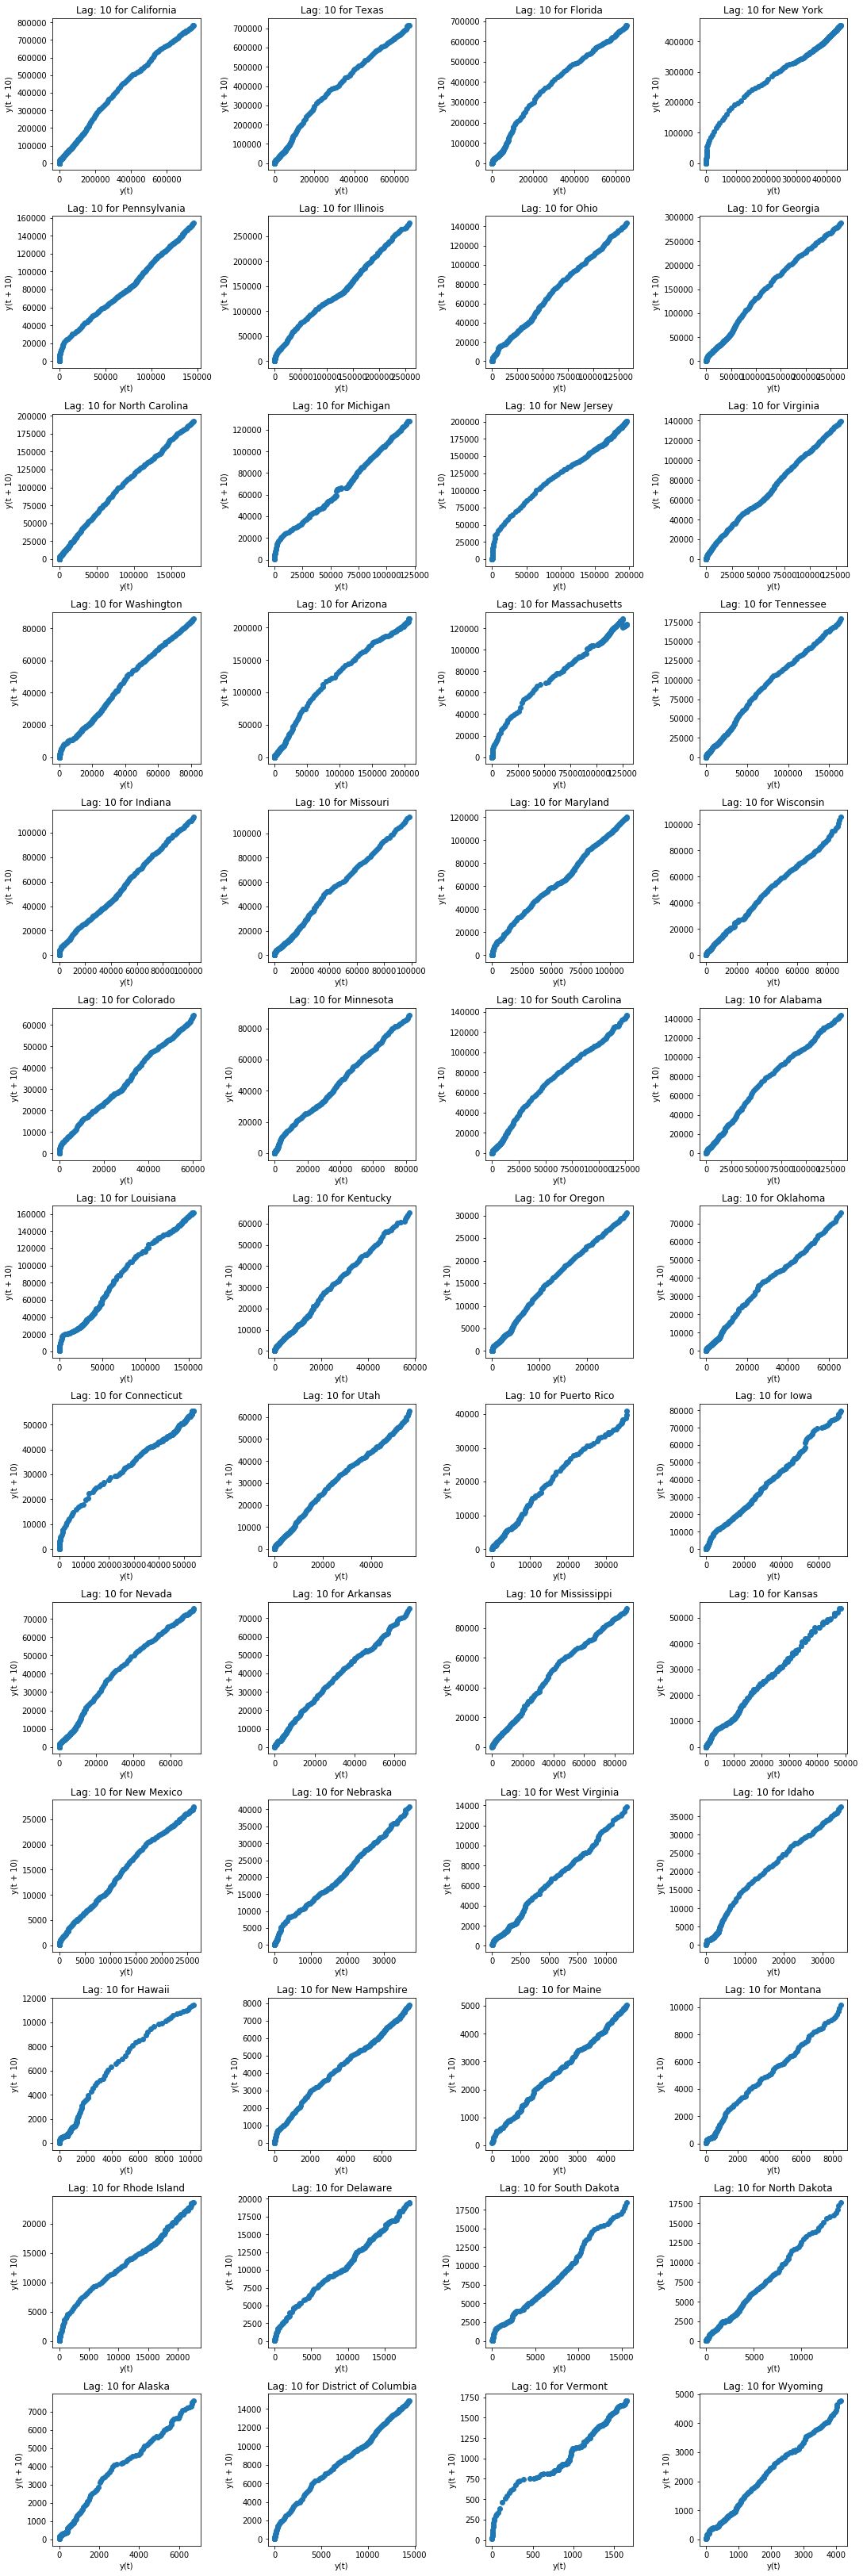

In [43]:
# plot_fn('cases', 'autocorr', **{'sharex': True, 'sharey': True})
plot_fn('cases', 'lag', **{'lag': 10, 'sharex': False, 'sharey': False})

As expected from the type of data and the lag plot, all the states show similar trend. All the states start stabilizing as seen below

Text(0.5, 1.0, 'Deaths')

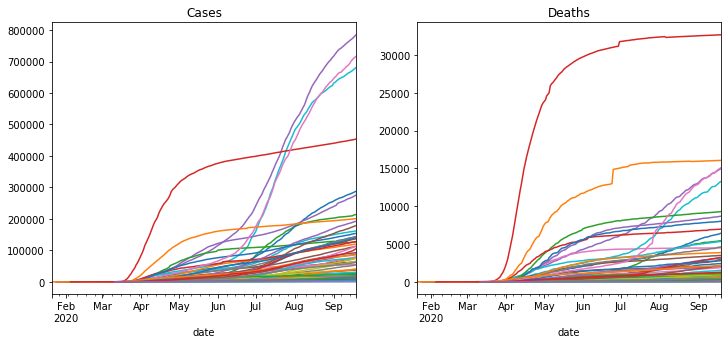

In [57]:
states_df = df.groupby('state')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

states_df.cases.plot(ax=axes[0]);
axes[0].set_title('Cases')
states_df.deaths.plot(ax=axes[1]);
axes[1].set_title('Deaths')

## Daily analysis for lag parameters

In [24]:
state_df = df[df.state=='Washington']
state_df

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
4,2020-01-24,Washington,53,1,0
7,2020-01-25,Washington,53,1,0
...,...,...,...,...,...
11065,2020-09-19,Washington,53,85886,2130
11120,2020-09-20,Washington,53,86169,2130
11175,2020-09-21,Washington,53,86803,2137
11230,2020-09-22,Washington,53,87233,2163


In [28]:
# Adding daily 

state_df['daily_cases']=state_df.cases.diff()
state_df['daily_deaths']=state_df.deaths.diff()
state_df

state_df['daily_cases'].fillna(state_df['cases'], inplace=True)
state_df['daily_deaths'].fillna(state_df['deaths'], inplace=True)
state_df

,date,state,fips,cases,deaths,daily_cases,daily_deaths
0,2020-01-21,Washington,53,1,0,1.0,0.0
1,2020-01-22,Washington,53,1,0,0.0,0.0
2,2020-01-23,Washington,53,1,0,0.0,0.0
4,2020-01-24,Washington,53,1,0,0.0,0.0
7,2020-01-25,Washington,53,1,0,0.0,0.0
...,...,...,...,...,...,...,...
11065,2020-09-19,Washington,53,85886,2130,303.0,0.0
11120,2020-09-20,Washington,53,86169,2130,283.0,0.0
11175,2020-09-21,Washington,53,86803,2137,634.0,7.0
11230,2020-09-22,Washington,53,87233,2163,430.0,26.0


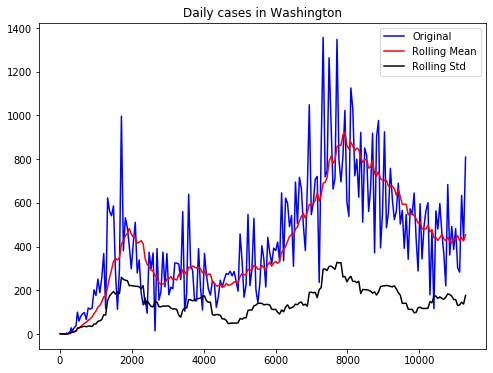

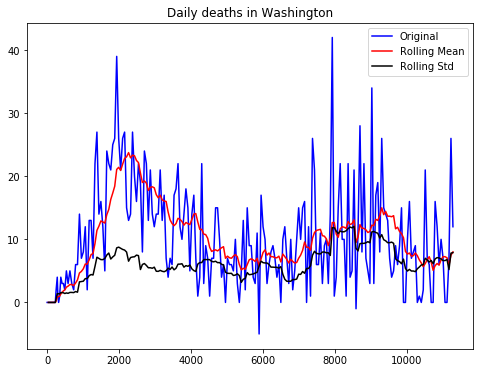

In [29]:
def test_stationarity(timeseries, title, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Daily {title} in Washington')
    plt.show()
    
test_stationarity(state_df['daily_cases'], title='cases')    
test_stationarity(state_df['daily_deaths'], title='deaths')    

The series is non-seasonal due to limited time observed, but it is non-stationary.

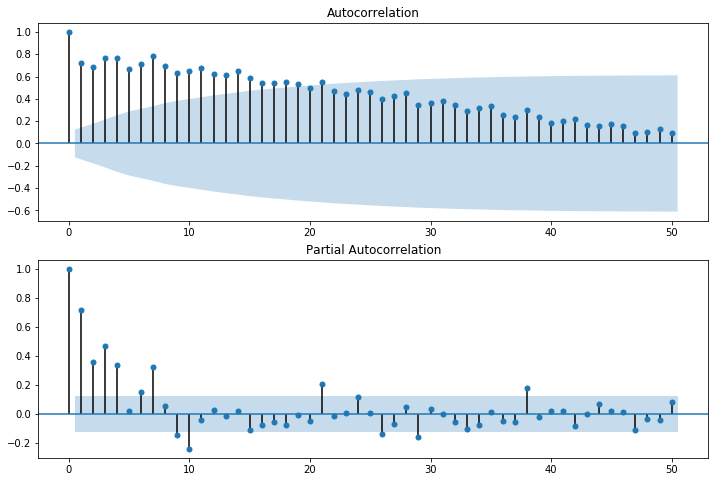

In [30]:
import statsmodels.api as sm

print('Analysis for daily cases:')
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df.daily_cases, lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df.daily_cases, lags=50, ax=ax2)

Here, the PACF displays a sharp cutoff while the ACF decays more slowly. Hence, an AR model will work for our situation with the cutoff being after 5 lag periods in PACF. Also, we have taken a difference over previous 1 period. Thus, the parameters for our time-series is:

|parameter|value|
|---|---|
|p|5|
|d|1|
|q|0|


Refer: https://people.duke.edu/~rnau/411arim3.htm

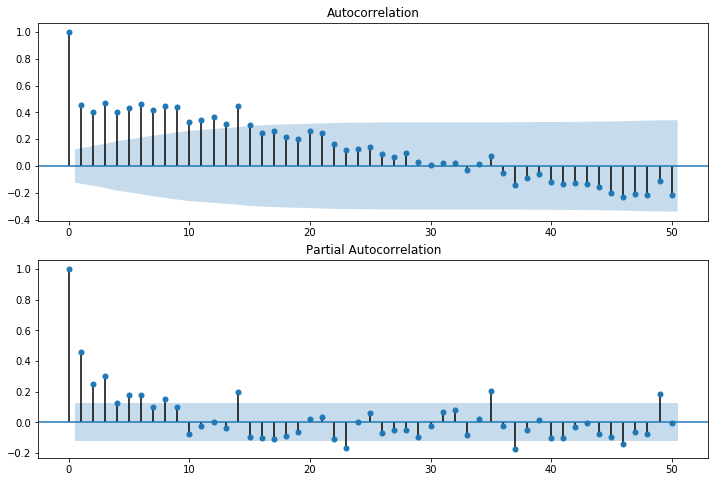

In [31]:
print('Analysis for daily deaths:')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df.daily_deaths, lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df.daily_deaths, lags=50, ax=ax2)

Even for estimation of deaths, we observe similar pattern, with the value of p being 4 instead.

# Model

## ARIMA Model

In [33]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [35]:
model = ARIMA(state_df.cases, order=(4,1,0))

C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [55]:
def ARIMA_forecast(series, split=0.8, **kwargs):
    L = len(series)
    size = int(np.floor(L*split))
    train, test = list(series[:size]), list(series[size:])
    
    order = kwargs.get('order', (5,1,0))
    
    history = list(train)#[x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        ypred = round(output[0][0])
        predictions.append(ypred)
        obs = test[t]
        history.append(obs)
        # print(f'predicted={ypred}, expected={obs}')
        
    error = mean_squared_error(test, predictions)
#     print(f'Test MSE: {error:0.3f}')

    return error, train, test, predictions

# we get daily cases by making the model with cases have d=1. So the result of daily_cases having d=0 is the same
results = ARIMA_forecast(state_df.cases, 0.9)    

In [56]:
def all_forecasts(df, col, **kwargs):
    total=0
    for s in df.state.unique():
        state_df = df[df.state==s]
        results = ARIMA_forecast(state_df[col], 0.9, **kwargs)  
        print(f'MSE for {s}: {results[0]}')
        total+=results[0]
        
    return total

all_forecasts(data, 'cases')        

MSE for Alabama: 86662.6
MSE for Alaska: 718.1
MSE for Arizona: 253112.12
MSE for Arkansas: 79282.9
MSE for California: 707722.32
MSE for Colorado: 9305.380952380952
MSE for Connecticut: 36916.85
MSE for Delaware: 3171.75
MSE for District of Columbia: 299.7142857142857
MSE for Florida: 522373.4761904762
MSE for Georgia: 271520.3333333333
MSE for Hawaii: 3255.0
MSE for Idaho: 13111.6
MSE for Illinois: 997444.68
MSE for Indiana: 51363.76190476191
MSE for Iowa: 42160.45
MSE for Kansas: 219871.0
MSE for Kentucky: 141170.38095238095
MSE for Louisiana: 171530.1
MSE for Maine: 102.65
MSE for Maryland: 28056.428571428572
MSE for Massachusetts: 4185735.7916666665
MSE for Michigan: 208143.55
MSE for Minnesota: 57597.333333333336
MSE for Mississippi: 47021.35
MSE for Missouri: 85588.80952380953
MSE for Montana: 2919.4
MSE for Nebraska: 21315.227272727272
MSE for Nevada: 13586.047619047618
MSE for New Hampshire: 278.8095238095238
MSE for New Jersey: 7387.857142857143
MSE for New Mexico: 2116.25
MS

C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


MSE for Utah: 22472.045454545456
MSE for Vermont: 10.19047619047619
MSE for Virginia: 50621.666666666664
MSE for Washington: 41813.68
MSE for West Virginia: 5103.3
MSE for Wisconsin: 169952.79166666666
MSE for Wyoming: 1152.6


33757322.27645398

In [59]:
kwargs = {'order': (3, 1, 0)}
all_forecasts(data, 'cases', **kwargs)        

MSE for Alabama: 89578.9
MSE for Alaska: 864.4
MSE for Arizona: 295706.48
MSE for Arkansas: 89552.65
MSE for California: 701317.8
MSE for Colorado: 8832.52380952381
MSE for Connecticut: 39480.1
MSE for Delaware: 3160.25
MSE for District of Columbia: 313.04761904761904
MSE for Florida: 654847.8571428572
MSE for Georgia: 305689.7619047619
MSE for Hawaii: 2826.6190476190477
MSE for Idaho: 12449.65
MSE for Illinois: 1109785.24
MSE for Indiana: 68380.85714285714
MSE for Iowa: 62572.05
MSE for Kansas: 361090.04761904763
MSE for Kentucky: 129672.57142857143
MSE for Louisiana: 216065.7
MSE for Maine: 102.1
MSE for Maryland: 24118.619047619046
MSE for Massachusetts: 4480887.958333333
MSE for Michigan: 214417.35
MSE for Minnesota: 61487.23809523809
MSE for Mississippi: 49048.8
MSE for Missouri: 79214.42857142857
MSE for Montana: 3139.25
MSE for Nebraska: 24761.81818181818
MSE for Nevada: 15382.190476190477
MSE for New Hampshire: 290.42857142857144
MSE for New Jersey: 6786.714285714285
MSE for Ne

36182856.32365801

In [89]:
train = [1,2,3,7.5,6.5,8.1,7]
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit(disp=0)

test = [7,8,9,10,11]
results = model_fit.forecast(steps=len(test))
# results = model_fit.forecast(steps=1)
results

(array([ 9.13640425,  9.62810706, 11.08755153, 11.99594725, 13.22032887]),
 array([1.60508231, 1.83249002, 2.25931304, 2.50162541, 2.78158488]),
 array([[ 5.99050072, 12.28230777],
        [ 6.03649262, 13.21972151],
        [ 6.65937934, 15.51572372],
        [ 7.09285155, 16.89904295],
        [ 7.76852269, 18.67213505]]))

(5, 2)


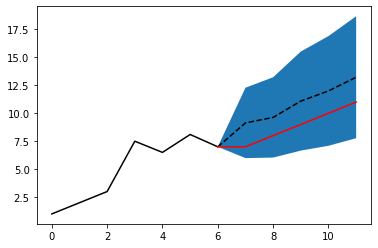

In [113]:
def plot_curve(train, test, results):
    pred, stderr, bounds = results
    
    xticks = list(range(len(train)+len(test))) # Temporary
    print(bounds.shape)#[:,0])
    
    # To merge with first column
    test = np.insert(test, 0, train[-1])
    pred = np.insert(pred, 0, train[-1])
    bounds = np.insert(bounds, 0, train[-1], axis=0)   # insert 0 at 0th row
    plt.plot(xticks[:len(train)], train, 'k')
    plt.plot(xticks[len(train)-1:], pred, '--k')    
    plt.plot(xticks[len(train)-1:], test, 'r')    
    plt.fill_between(xticks[len(train)-1:], bounds[:,0], bounds[:,1])    
    
plot_curve(train, test, results)    

## RNN Model

In [22]:
data

,date,state,fips,cases,deaths,Recent_population
0,2020-03-13,Alabama,1,6,0,4903185
1,2020-03-14,Alabama,1,12,0,4903185
2,2020-03-15,Alabama,1,23,0,4903185
3,2020-03-16,Alabama,1,29,0,4903185
4,2020-03-17,Alabama,1,39,0,4903185
...,...,...,...,...,...,...
10613,2020-09-17,Wyoming,56,4652,49,578759
10614,2020-09-18,Wyoming,56,4747,49,578759
10615,2020-09-19,Wyoming,56,4780,49,578759
10616,2020-09-20,Wyoming,56,4871,49,578759


In [25]:
states = data.state.unique()
data[data.state==states[0]]

,date,state,fips,cases,deaths,Recent_population
0,2020-03-13,Alabama,1,6,0,4903185
1,2020-03-14,Alabama,1,12,0,4903185
2,2020-03-15,Alabama,1,23,0,4903185
3,2020-03-16,Alabama,1,29,0,4903185
4,2020-03-17,Alabama,1,39,0,4903185
...,...,...,...,...,...,...
188,2020-09-17,Alabama,1,141757,2401,4903185
189,2020-09-18,Alabama,1,142863,2428,4903185
190,2020-09-19,Alabama,1,144164,2437,4903185
191,2020-09-20,Alabama,1,144962,2437,4903185


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


class TimeSeriesDataset(Dataset):
    
    def __init__(self, data, window):
        self.data = data
        self.window = window
#         self.X
#         self.Y

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self):
        

In [43]:
model.forecast()

AttributeError: 'ARIMA' object has no attribute 'forecast'